In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, RNN, Flatten
from keras.regularizers import l2

from kerastuner.tuners import RandomSearch
from keras.optimizers import Adam, SGD, RMSprop, Nadam, Adagrad

2024-07-28 10:54:26.868417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/zb/nl25s0l50sl0r6n18b3fm3w00000gp/T/ipykernel_98179/3303139053.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Data analysis and preparation

In [8]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)


# Получение словаря индексов и слов
word_index = imdb.get_word_index() 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in input_train[10]])
print(decoded_review)


### Padding
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)

? french horror cinema has seen something of a revival over the last couple of years with great films such as inside and ? romance ? on to the scene ? ? the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made ? was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is ? by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named ? sent to prison for fraud he is put in a cell with three others the quietly insane ? body building ? marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old ? after ? part of it they soon realise its magical powers and realise they may be able to use it to break through the prison walls br br black magi

# Building and Comparing Recurrent Models

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Установим коллбэки для остановки обучения при отсутствии улучшений и уменьшения скорости обучения
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

def plot_acc_loss_history(history, title=""):
    plt.figure(figsize=(13,3))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")  
    plt.fill_between(range(len(history.history['accuracy'])), history.history['accuracy'], history.history['val_accuracy'], alpha=0.2)
    plt.grid()
    plt.xticks(range(1, len(history.history['accuracy'])+1))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.fill_between(range(len(history.history['loss'])), history.history['loss'], history.history['val_loss'], alpha=0.2)
    plt.grid()
    plt.xticks(range(1, len(history.history['loss'])+1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    if len(title):
        plt.suptitle(title, fontsize=20)
    plt.show()


def make_predictions(model, name: str):

    predictions = model.predict(input_test)

    # Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
    binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

    # Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
    for i in range(10):
        print(f"Predicted: {binary_predictions[i]}, Actual: {y_test[i]}")

    # Додатковий крок: Оцінка моделі
    # Це дасть загальну точність моделі на тестових даних
    test_loss, test_acc = model.evaluate(input_test, y_test)
    print(name,' Test Loss: {}'.format(test_loss))
    print(name, ' Test Accuracy: {}'.format(test_acc))

### Selection of hyperparameters with Kerastuner

Trial 7 Complete [00h 35m 02s]
val_accuracy: 0.8794400095939636

Best val_accuracy So Far: 0.8899199962615967
Total elapsed time: 13h 36m 20s
Hyperparameter search time: 48980.30 seconds
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 gru (GRU)                   (None, 160)               108480    
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 96)                15456     
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
T

2024-07-29 06:38:49.155344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-29 06:38:49.157702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-29 06:38:49.158624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9390

2024-07-29 06:43:36.364016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-29 06:43:36.366920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-29 06:43:36.367984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 385s 490ms/step - loss: 0.1872 - accuracy: 0.9390 - val_loss: 0.3025 - val_accuracy: 0.8886 - lr: 6.0375e-05
Epoch 2/20
782/782 [==============================] - 381s 487ms/step - loss: 0.1848 - accuracy: 0.9393 - val_loss: 0.3109 - val_accuracy: 0.8877 - lr: 6.0375e-05
Epoch 3/20
782/782 [==============================] - 387s 495ms/step - loss: 0.1839 - accuracy: 0.9400 - val_loss: 0.3287 - val_accuracy: 0.8865 - lr: 6.0375e-05
Epoch 4/20
782/782 [==============================] - 381s 487ms/step - loss: 0.1811 - accuracy: 0.9402 - val_loss: 0.2940 - val_accuracy: 0.8860 - lr: 6.0375e-05
Epoch 5/20
782/782 [==============================] - 381s 487ms/step - loss: 0.1792 - accuracy: 0.9402 - val_loss: 0.2929 - val_accuracy: 0.8868 - lr: 6.0375e-05
Epoch 6/20
782/782 [==============================] - 381s 487ms/step - loss: 0.1782 - accuracy: 0.9409 - val_loss: 0.3006 - val_accuracy: 0.8854 - lr: 6.0375e-05
Epoch 7/20
782/782 [=============

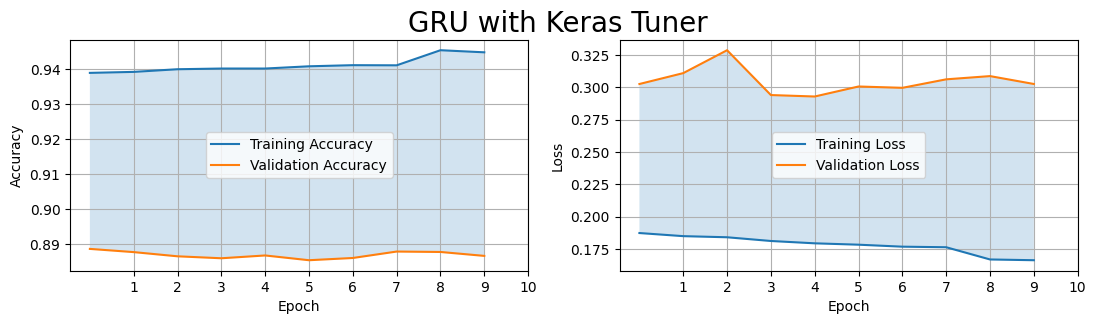

2024-07-29 07:44:11.470190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-29 07:44:11.472958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-29 07:44:11.473957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 101s 129ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 103s 132ms/step - loss: 0.2929 - accuracy: 0.8868
GRU with Keras Tuner  Test Loss: 0.29285016655921936
GRU with Keras Tuner  Test Accuracy: 0.8867599964141846


In [9]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(max_features, 
                        hp.Int('embedding_dim', min_value=16, max_value=64, step=16),
                        input_length=maxlen))
    
    model.add(GRU(hp.Int('gru_units', min_value=32, max_value=256, step=32), 
                  kernel_regularizer=l2(hp.Float('l2_reg', min_value=0.01, max_value=0.1, step=0.01)),
                  return_sequences=False))
    
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), 
                    activation='relu', 
                    kernel_regularizer=l2(hp.Float('l2_reg', min_value=0.01, max_value=0.1, step=0.01))))
    
    model.add(Dense(1, activation='sigmoid'))

    # Обираємо оптимізатор та швидкість навчання
    optimizer_choice = hp.Choice(
        "optimizer", ["adam", "rmsprop", "nadam"]
    )
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    if optimizer_choice == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == "rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == "nadam":
        optimizer = Nadam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=["accuracy"],
    )

    return model


tuner = RandomSearch(
    hypermodel=build_model,  # Функція побудови моделі, яка є build_modelв нашому випадку.
    objective="val_accuracy",  # Назва цілі, яку потрібно оптимізувати (мінімізувати чи максимізувати)
    max_trials=7,  # Загальна кількість спроб, які потрібно виконати під час пошуку.
    executions_per_trial=1,  # Кількість моделей, які слід створити та підібрати для кожного випробування.
    # Якщо ви хочете отримати результати швидше, ви можете встановити executions_per_trial=1(один цикл навчання для кожної конфігурації моделі).
    overwrite=True,  # чи перезаписувати попередні результати в тому самому каталозі
    directory="my_dir",
    project_name="imdb",
)
tuner.search_space_summary()


# Поиск гиперпараметров с измерением времени
start_time = time.time()
tuner.search(
    input_train,
    y_train,
    epochs=25,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
search_time = end_time - start_time
print(f"Hyperparameter search time: {search_time:.2f} seconds")

# Получение лучшей модели
best_model = tuner.get_best_models(num_models=1)[0]
print(best_model.summary())


# Model training and evaluation
b_start_time = time.time()
b_history = best_model.fit(
    input_train,
    y_train,
    epochs=20,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
b_end_time = time.time()
b_training_time = b_end_time - b_start_time

b_test_loss, b_test_acc = best_model.evaluate(input_test, y_test)
print(f"Model training time for MODEL with TUNER: {b_training_time:.2f} seconds")

plot_acc_loss_history(b_history, "GRU with Keras Tuner")
make_predictions(best_model, "GRU with Keras Tuner")

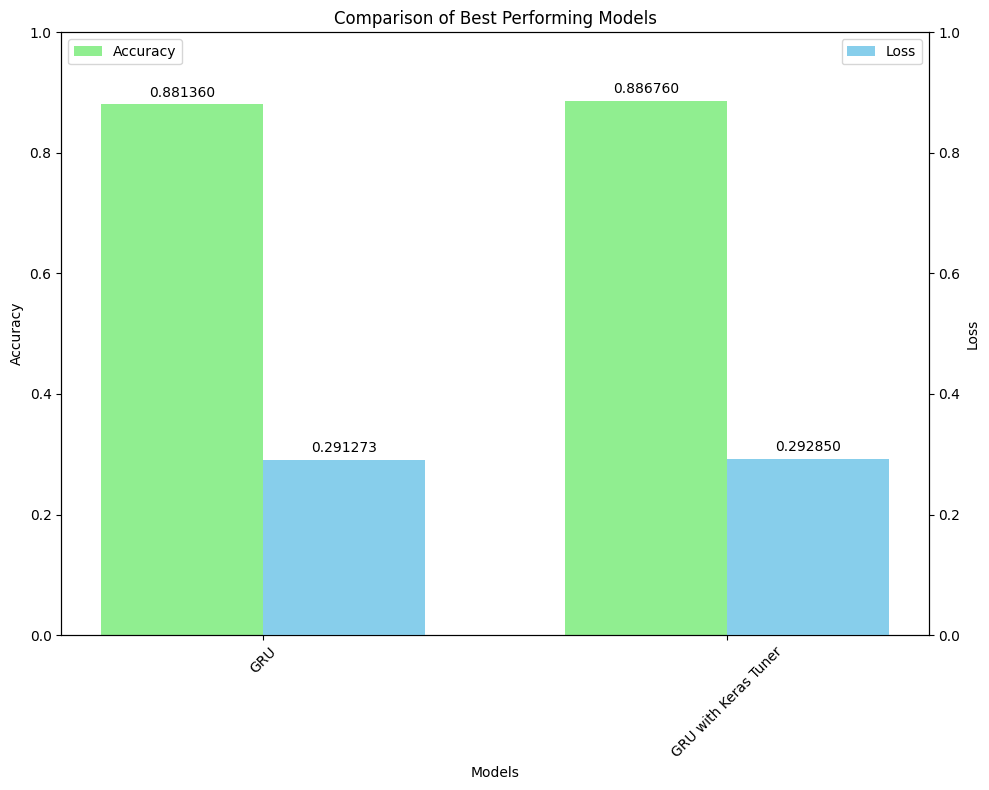

In [14]:
model_names = ['GRU', 'GRU with Keras Tuner']
test_accuracies = [0.8813599944114685, 0.8867599964141846] 
test_losses = [0.29127341508865356, 0.29285016655921936]


# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# Ширина столбцов
width = 0.35

# Позиции для столбцов
x = np.arange(len(model_names))

# Создаем столбцы для MSE и R^2
rects1 = ax1.bar(x - width/2, test_accuracies, width, label='Accuracy', color='lightgreen')
rects2 = ax2.bar(x + width/2, test_losses, width, label='Loss', color='skyblue')

# Настройка осей и меток
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)

ax1.set_ylim(0, 1)  # Устанавливаем пределы для 'Accuracy'
ax2.set_ylim(0, 1)  # Устанавливаем пределы для loss

# Добавляем значения на столбцы
def autolabel(rects, ax, fmt='{:.6f}'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(fmt.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects2, ax2)
autolabel(rects1, ax1, fmt='{:.6f}')

# Добавляем легенду
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Comparison of Best Performing Models')
plt.tight_layout()
plt.show()

# Conclusion


**Accuracy:**

- GRU Model: 0.8813599944114685
- GRU with Keras Tuner: 0.8867599964141846


**Loss:**

- GRU Model: 0.29127341508865356
- GRU with Keras Tuner: 0.29285016655921936

**Summary**

The use of Keras Tuner to optimize hyperparameters led to a slight improvement in the accuracy of the GRU model, increasing from 0.8814 to 0.8868. However, there was a marginal increase in the loss from 0.2913 to 0.2929. This suggests that while the tuned model was able to generalize slightly better, it did not significantly affect the overall performance, maintaining similar loss values.

Additionally, the hyperparameter tuning process with Keras Tuner was time-consuming, taking a total elapsed time of 13 hours, 36 minutes, and 20 seconds, with the actual hyperparameter search taking approximately 48,980.30 seconds. This significant time investment highlights the computational expense associated with finding optimal hyperparameters.


**Підсумок**

Використання Keras Tuner для оптимізації гіперпараметрів призвело до незначного покращення точності моделі GRU, яка зросла з 0.8814 до 0.8868. Однак, було зафіксовано незначне збільшення значення втрат з 0.2913 до 0.2929. Це свідчить про те, що, хоча оптимізована модель змогла трохи краще узагальнювати, це незначно вплинуло на загальну продуктивність, оскільки втрати залишилися майже незмінними.

Крім того, процес налаштування гіперпараметрів за допомогою Keras Tuner був досить тривалим, зайнявши загальний час у 13 годин, 36 хвилин і 20 секунд, а безпосередній пошук гіперпараметрів тривав приблизно 48,980.30 секунд. Цей значний часовий ресурс підкреслює високі обчислювальні витрати, пов’язані з пошуком оптимальних гіперпараметрів.